Looking into schedule changes for SHAVUOT (שבועות) 2018.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ftplib import FTP
import datetime
import re
import zipfile
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7) # set default size of plots

sns.set_style("white")
sns.set_context("talk")
sns.set_palette('Set1', 10)

## Get the data
I get all the files from our GTFS repository at הסדנא - it is not still openly accessible, but you can ask me for files or access if you need it.  

## Tidy it up
Using [partridge](https://github.com/remix/partridge/tree/master/partridge) for filtering on dates, and then some tidying up and transformations.

In [2]:
from gtfs_utils import *

TARIFF_FILE_NAME = 'Tariff.zip'
TARIFF_TXT_NAME = 'Tariff.txt'
TARIFF_TO_REFORM_ZONE = 'StationToReformZone.txt'
local_tariff_path = 'data/sample/tariff.zip' 

conn = ftp_connect()
get_ftp_file(conn, file_name = TARIFF_FILE_NAME, local_zip_path = local_tariff_path )

### Tariff stuff for zone names

In [3]:
# not a true csv, so we need to jiggle it a bit
cols = ['ShareCode','ShareCodeDesc','ZoneCodes','Daily','Weekly','Monthly','FromDate','ToDate', 'EXTRA']
reform_cols = ['StationId', 'ReformZoneCode','FromDate','ToDate', 'EXTRA']
with zipfile.ZipFile(local_tariff_path) as zf:
    tariff_df = (pd.read_csv(zf.open(TARIFF_TXT_NAME), header=None, skiprows=[0], names = cols)
                .drop(columns = ['EXTRA']))
    reform_df = (pd.read_csv(zf.open(TARIFF_TO_REFORM_ZONE), header=None, skiprows=[0], names = reform_cols)
                 .drop(columns = ['EXTRA']))

    
# remove ShareCodes which contain multiple zones  e.g. גוש דן מורחב
tariff_df = (tariff_df[~ tariff_df.ZoneCodes.str.contains(';')]
             .rename(columns = {'ShareCodeDesc': 'zone_name',
                               'ZoneCodes': 'zone_id'}))
rs = reform_df[['StationId', 'ReformZoneCode']].drop_duplicates().applymap(str).set_index('StationId').iloc[:,0]

ts = (tariff_df[['zone_id', 'zone_name']].drop_duplicates().set_index('zone_id').iloc[:,0])
zones = rs.map(ts).reset_index().rename(columns={'StationId': 'stop_code', 'ReformZoneCode':'zone_name'})

In [40]:
import partridge as ptg

def get_partridge_feed(zip_path, date):
    service_ids_by_date = ptg.read_service_ids_by_date(zip_path)
    service_ids = service_ids_by_date[date]

    feed = ptg.feed(zip_path, view={
        'trips.txt': {
            'service_id': service_ids,
        },
    })
    return feed
    
def to_timedelta(df):
    '''
    Turn time columns into timedelta dtype
    '''
    cols = ['arrival_time', 'departure_time']
    numeric = df[cols].apply(pd.to_timedelta, unit='s')
    df = df.copy()
    df[cols] = numeric
    return df

def get_tidy_feed_df(feed, zones):
    s = feed.stops
    r = feed.routes
    a = feed.agency
    t = (feed.trips
         .assign(route_id=lambda x: pd.Categorical(x['route_id'])))
    f = (feed.stop_times[['trip_id', 'departure_time', 'arrival_time', 'stop_id', 'stop_sequence']]
         .merge(s[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'stop_code']], on='stop_id')
         # Much faster joins and slices with Categorical dtypes
         .merge(zones, how='left')
         .assign(zone_name=lambda x: pd.Categorical(x['zone_name']))
         .merge(t[['trip_id', 'route_id', 'direction_id']], on='trip_id', how='left')
         .merge(r[['route_id', 'route_short_name', 'route_long_name', 'agency_id']], on='route_id', how='left')
         .assign(route_id=lambda x: pd.Categorical(x['route_id']))
         .assign(agency_id=lambda x: pd.Categorical(x['agency_id']))
         .merge(a[['agency_id', 'agency_name']], on='agency_id', how='left')
         .assign(agency_name=lambda x: pd.Categorical(x['agency_name']))
         .pipe(to_timedelta)
        )
    return f

In [37]:
LOCAL_ZIP_PATH1 = 'data/gtfs_feeds/2018-05-15.zip' 

### feeds

In [12]:
feed20 = get_partridge_feed(LOCAL_ZIP_PATH1, datetime.date(2018, 5, 20))
feed19 = get_partridge_feed(LOCAL_ZIP_PATH1, datetime.date(2018, 5, 19))

In [13]:
print('19.5: %d נסיעות' % ((feed19.trips.shape[0])))
print('20.5: %d נסיעות' % ((feed20.trips.shape[0])))
print('(20.5 - 19.5): %.2f הפרש באחוזים' % ((feed20.trips.shape[0] - feed19.trips.shape[0])/feed20.trips.shape[0]))


19.5: 4183 נסיעות
20.5: 23845 נסיעות
(20.5 - 19.5): 0.82 הפרש באחוזים


In [41]:
f20 = get_tidy_feed_df(feed20, zones)
f19 = get_tidy_feed_df(feed19, zones)

In [42]:
f19.head()

,trip_id,departure_time,arrival_time,stop_id,stop_sequence,stop_name,stop_lat,stop_lon,stop_code,zone_name,route_id,direction_id,route_short_name,route_long_name,agency_id,agency_name
0,25418516_140518,21:45:00,21:45:00,37318,1,ירושלים מלחה,31.747801,35.188216,17078,סובב ירושלים,12453,1,NaN,ירושלים מלחה-ירושלים<->תל אביב מרכז-תל אביב יפו,2,רכבת ישראל
1,31551831_140518,23:45:00,23:45:00,37318,7,ירושלים מלחה,31.747801,35.188216,17078,סובב ירושלים,12455,0,NaN,תל אביב מרכז-תל אביב יפו<->ירושלים מלחה-ירושלים,2,רכבת ישראל
2,25418516_140518,22:23:00,22:23:00,37322,2,בית שמש,31.757821,34.989515,17074,אזור בית שמש,12453,1,NaN,ירושלים מלחה-ירושלים<->תל אביב מרכז-תל אביב יפו,2,רכבת ישראל
3,31551831_140518,23:05:00,23:05:00,37322,6,בית שמש,31.757821,34.989515,17074,אזור בית שמש,12455,0,NaN,תל אביב מרכז-תל אביב יפו<->ירושלים מלחה-ירושלים,2,רכבת ישראל
4,25418516_140518,22:43:00,22:43:00,37336,3,רמלה,31.928809,34.877304,17060,גוש דן,12453,1,NaN,ירושלים מלחה-ירושלים<->תל אביב מרכז-תל אביב יפו,2,רכבת ישראל


In [15]:
zones.zone_name.value_counts()

גוש דן                       4551
סובב ירושלים                 2800
סובב חיפה                    2416
נתניה                        1610
שרון                         1472
נצרת                         1421
נהריה                        1312
גליל עליון ורמת הגולן        1294
כרמיאל                       1039
חריש ואדי ערה                1003
עכו                           987
אשדוד                         968
רחובות                        927
באר שבע                       842
ראש העין שוהם                 824
אשקלון                        775
סובב כנרת ודרום רמת הגולן     700
עפולה                         678
יוקנעם- טבעון                 670
חבל מודיעין                   668
ערד דימונה                    619
נתיבות שדרות                  561
אזור בית שמש                  525
אזור חדרה                     484
רהט להבים                     460
הרי ירושלים                   432
קריית גת                      343
בית שאן                       326
השומרון                       318
אופקים        

### Agencies in Jerusalem

In [16]:
rs = f19[f19.zone_name=="סובב ירושלים"].groupby(['route_id']).size()
ags = feed19.routes[feed19.routes.route_id.isin(rs[rs>0].index)].agency_id.value_counts()
feed19.agency[feed19.agency.agency_id.isin(ags.index)].set_index('agency_name').agency_id.map(ags)

agency_name
רכבת ישראל                              2
ירושלים-רמאללה איחוד                    7
ירושלים-אבו-תור-ענאתא איחוד             7
ירושלים-אלווסט איחוד                   10
ירושלים-הר הזיתים                       7
ירושלים - עיסאוויה מחנה שעפאט איחוד     5
ירושלים-דרום איחוד                      6
ירושלים-צור באהר איחוד                  6
Name: agency_id, dtype: int64

In [18]:
feed19.agency

,agency_id,agency_name,agency_url,agency_timezone,agency_lang,agency_phone,agency_fare_url
0,2,רכבת ישראל,http://www.rail.co.il,Asia/Jerusalem,he,NaN,NaN
1,3,אגד,http://www.egged.co.il,Asia/Jerusalem,he,NaN,NaN
4,6,ש.א.מ,http://www.nazareth-unbs.com,Asia/Jerusalem,he,NaN,NaN
5,7,נסיעות ותיירות,http://www.ntt-buses.com,Asia/Jerusalem,he,NaN,NaN
6,8,גי.בי.טורס,http://www.gb-tours.com,Asia/Jerusalem,he,NaN,NaN
7,14,נתיב אקספרס,http://www.nateevexpress.com,Asia/Jerusalem,he,NaN,NaN
9,16,סופרבוס,http://www.superbus.co.il,Asia/Jerusalem,he,NaN,NaN
10,18,קווים,http://www.kavim-t.co.il,Asia/Jerusalem,he,NaN,NaN
13,23,גלים,http://www.galeem.co.il/,Asia/Jerusalem,he,NaN,NaN
16,30,דן צפון,http://www.haifahaifa.co.il/archives/5622,Asia/Jerusalem,he,NaN,NaN


In [21]:
f19[(f19.zone_name=="סובב ירושלים") & (f19.agency_id=='2')]

,trip_id,departure_time,arrival_time,stop_id,stop_sequence,stop_name,stop_lat,stop_lon,stop_code,zone_name,route_id,direction_id,route_short_name,route_long_name,agency_id
0,25418516_140518,21:45:00,21:45:00,37318,1,ירושלים מלחה,31.747801,35.188216,17078,סובב ירושלים,12453,1,NaN,ירושלים מלחה-ירושלים<->תל אביב מרכז-תל אביב יפו,2
8,31551831_140518,23:45:00,23:45:00,37318,7,ירושלים מלחה,31.747801,35.188216,17078,סובב ירושלים,12455,0,NaN,תל אביב מרכז-תל אביב יפו<->ירושלים מלחה-ירושלים,2


### Zone-specific difference ratio

In [25]:
jer = f20[f20.zone_name=="סובב ירושלים"].trip_id.nunique() - f19[f19.zone_name=="סובב ירושלים"].trip_id.nunique()
hai = f20[f20.zone_name=="סובב חיפה"].trip_id.nunique() - f19[f19.zone_name=="סובב חיפה"].trip_id.nunique()
naz = f20[f20.zone_name=="נצרת"].trip_id.nunique() - f19[f19.zone_name=="נצרת"].trip_id.nunique()


In [27]:
print('ירושלים: %.2f הפרש באחוזים' % (jer / f20[f20.zone_name=="סובב ירושלים"].trip_id.nunique()))
print('חיפה: %.2f הפרש באחוזים' % (hai / f20[f20.zone_name=="סובב חיפה"].trip_id.nunique()))
print('נצרת: %.2f הפרש באחוזים' % (naz / f20[f20.zone_name=="נצרת"].trip_id.nunique()))



ירושלים: 0.69 הפרש באחוזים
חיפה: 0.95 הפרש באחוזים
נצרת: 0.18 הפרש באחוזים


### Per route trip count difference

In [33]:
rcmp = pd.concat([feed19.trips.route_id.value_counts(), feed20.trips.route_id.value_counts()], axis=1, keys=['feed19', 'feed20'])

rcmp['dif'] = rcmp.feed19.subtract(rcmp.feed20)
pd.concat((rcmp, feed19.routes.set_index('route_id')[['route_short_name', 'route_long_name']]), axis=1).sort_values(by='dif', ascending=False).head(20)

,feed19,feed20,dif,route_short_name,route_long_name
1266,31.0,14.0,17.0,9,7045/7040-נצרת<->7042/7040-נצרת-3#
11688,62.0,45.0,17.0,1,ת. מרכזית חוף הכרמל/רציף לילה ושבת-חיפה<->מרכז...
1315,31.0,15.0,16.0,15,בית ספר תיכון שנלר-נצרת<->בית ספר תיכון שנלר-נ...
11692,62.0,46.0,16.0,1,מרכזית הקריות-קרית מוצקין<->ת. מרכזית חוף הכרמ...
1256,29.0,15.0,14.0,6,אלכרום/יציאה-נצרת<->בית ספר נעמ''ת-נצרת-2#
1254,29.0,16.0,13.0,6,בית ספר נעמ''ת-נצרת<->9004/5026-נצרת-1#
17084,43.0,31.0,12.0,7,609/616-יפיע<->בי''ס סנט ג'וזף-נצרת-1#
17086,42.0,30.0,12.0,7,בית ספר סנט גוזף-נצרת<->609/616-יפיע-2#
1209,49.0,38.0,11.0,1,יפיע ד'/יציאה-יפיע<->מרכז מסחרי/המעיין-נצרת עי...
1324,20.0,10.0,10.0,18,10297-ריינה<->10297-ריינה-3#


### Per minute departure difference

In [34]:
se = (feed20.stop_times.groupby(['trip_id'])
     .agg({'departure_time': 'min',
          'arrival_time': 'max'})
     .pipe(to_timedelta)
     .sort_values(['arrival_time', 'departure_time']))
se.head()

,departure_time,arrival_time
trip_id,,
25324576_200518,00:00:00,00:33:09
12340892_200518,00:05:00,00:41:56
15996056_200518,00:00:00,00:54:22
15996062_200518,00:00:00,00:55:29
4322807_200518,00:00:00,00:56:03


In [35]:
se2 = (feed19.stop_times.groupby(['trip_id'])
     .agg({'departure_time': 'min',
          'arrival_time': 'max'})
     .pipe(to_timedelta)
     .sort_values(['arrival_time', 'departure_time']))
se2.head()

,departure_time,arrival_time
trip_id,,
32285973_190518,0 days,00:54:22
32283710_190518,0 days,00:55:29
32288313_190518,0 days,00:56:03
32285497_190518,0 days,01:01:36
17565277_190518,0 days,01:02:08


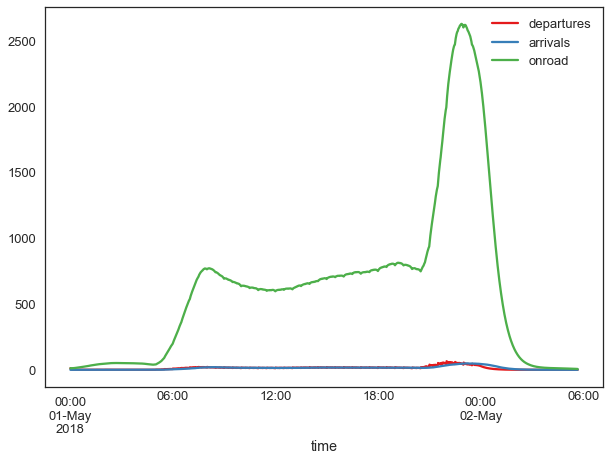

In [50]:
departures = pd.Series(1, se.departure_time).resample('1Min').sum()
arrivals =  pd.Series(1, se.arrival_time).resample('T').sum()
onroad = pd.concat([pd.Series(1, se.departure_time),  # departed add 1
                           pd.Series(-1, se.arrival_time)  # arrived substract 1
                           ]).resample('1Min').sum().cumsum().ffill()
df = (pd.concat([departures, arrivals, onroad], axis=1).reset_index()
        .rename(columns={'index': 'time', 0:'departures', 1:'arrivals', 2:'onroad'}))
idx = pd.DatetimeIndex(df.time+datetime.datetime(2018, 5, 1))

(df.assign(time=idx)
 .set_index('time')
 .resample('1min').sum()
 .ewm(span=60)
 .mean()
 .plot())

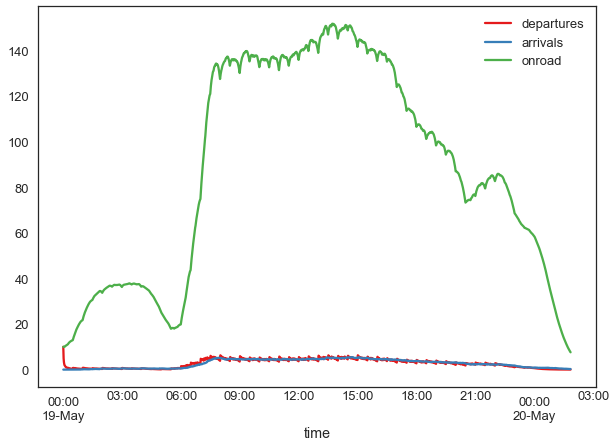

In [51]:
departures2 = pd.Series(1, se2.departure_time).resample('1Min').sum()
arrivals2 =  pd.Series(1, se2.arrival_time).resample('T').sum()
onroad2 = pd.concat([pd.Series(1, se2.departure_time),  # departed add 1
                           pd.Series(-1, se2.arrival_time)  # arrived substract 1
                           ]).resample('1Min').sum().cumsum().ffill()
df2 = (pd.concat([departures2, arrivals2, onroad2], axis=1).reset_index()
        .rename(columns={'index': 'time', 0:'departures', 1:'arrivals', 2:'onroad'}))
#idx = pd.DatetimeIndex(df.time+datetime.datetime(2018, 5, 1))
idx = pd.DatetimeIndex(df2.time+datetime.datetime(2018, 5,19))

(df2.assign(time=idx)
 .set_index('time')
 .resample('1min').sum()
 .ewm(span=60)
 .mean()
 .plot())

This looks almost the same, lets line the departures up

Text(0,0.5,'הקדל תואיצי')

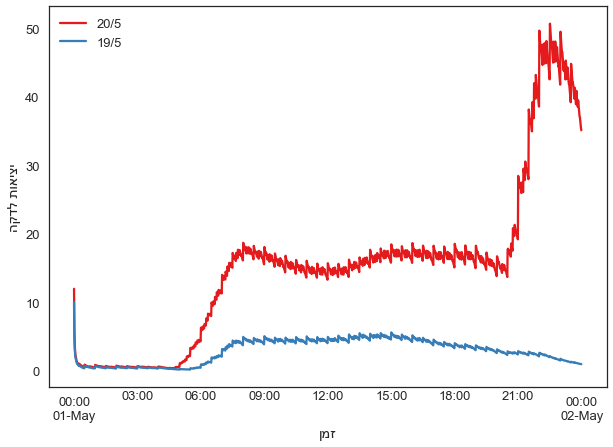

In [47]:
idx = pd.DatetimeIndex(departures.index+datetime.datetime(2018, 5, 1))

df_m = (pd.concat([departures, departures2], axis=1).reset_index()
        .rename(columns={'index': 'time', 1:'19/5', 0:'20/5'}))
fig, ax = plt.subplots()

(df_m.assign(time=idx)
 .set_index('time')
 .resample('1min').sum()
 .ewm(span=120)
 .mean()
 .plot(ax=ax))

ax.set_xlabel('ןמז')
ax.set_ylabel('הקדל תואיצי')
#ax.set_title('Departures Per Minute (smoothed)')

## Altair

In [22]:
import altair as alt

# Altair plots render by default in JupyterLab and nteract

# Uncomment/run this line to enable Altair in the classic notebook (not in JupyterLab)
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [49]:
idx = pd.DatetimeIndex(f19[f19.stop_sequence==1].departure_time+datetime.datetime(2018, 5,19))
idx

DatetimeIndex(['2018-05-19 21:45:00', '2018-05-19 22:24:00',
               '2018-05-19 20:46:00', '2018-05-19 21:13:00',
               '2018-05-19 20:53:00', '2018-05-19 22:20:00',
               '2018-05-19 20:49:00', '2018-05-19 22:51:00',
               '2018-05-19 23:48:00', '2018-05-19 21:49:00',
               ...
               '2018-05-19 10:00:00', '2018-05-19 11:00:00',
               '2018-05-19 12:00:00', '2018-05-19 13:00:00',
               '2018-05-19 14:00:00', '2018-05-19 15:00:00',
               '2018-05-19 16:00:00', '2018-05-19 17:00:00',
               '2018-05-19 18:00:00', '2018-05-19 19:00:00'],
              dtype='datetime64[ns]', name='departure_time', length=4183, freq=None)

In [78]:
deps = (f19[f19.stop_sequence==1]
        .assign(time=idx))[['time', 'agency_name']]


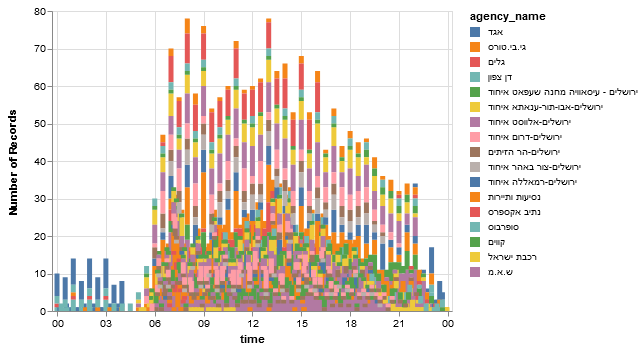

In [111]:
base = alt.Chart(deps).mark_bar(binSpacing=0).encode(
    x=alt.X('time:T', axis=alt.Axis(format='%H')),
    y=alt.Y('count()'),
    color='agency_name:N',
    tooltip='agency_name:N'
)

base

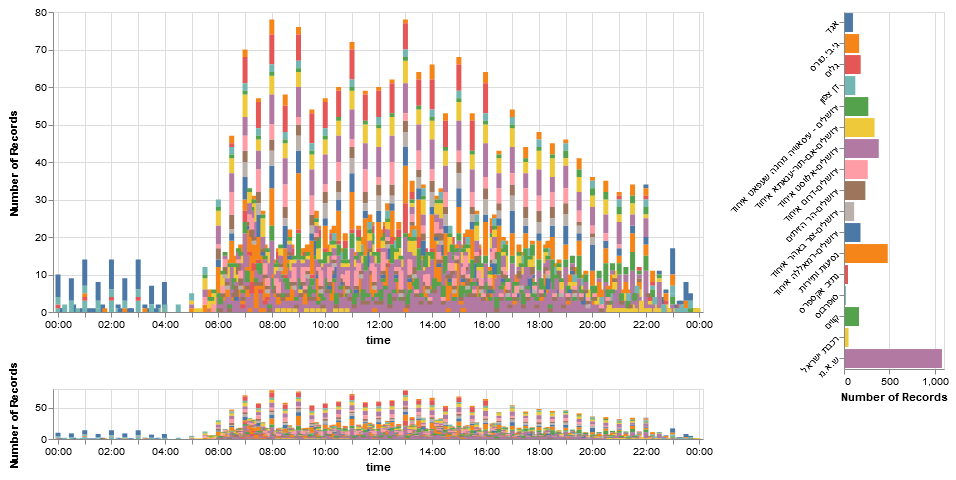

In [150]:
interval = alt.selection_interval(encodings=['x'])
click = alt.selection_multi(encodings=['color'])

chart = base.properties(
    width=650,
    height=300
).encode(
    x=alt.X('time:T', scale=alt.Scale(domain=interval.ref() ), axis=alt.Axis(format='%H:%M')),
    color=alt.condition(click, 'agency_name:N', alt.value('lightgray'), legend=None)
)

view = chart.properties(
    width=650,
    height=50,
    selection=interval
)
hist = alt.Chart(deps).mark_bar().encode(
    x=alt.X('count()'),
    y=alt.Y('agency_name:N', axis=alt.Axis(title=None, labelAngle=-45)),
    color=alt.condition(click, 'agency_name:N', alt.value('lightgray'), legend=None)
).properties(
    selection=click,
    width=100,    
)

(chart & view | hist)